In [1]:
import Pkg

Pkg.activate(@__DIR__)
Pkg.instantiate();

  Activating project at `~/gits/DisjunctiveToQUBO.jl/notebooks`


In [11]:
using JuMP
using Plots
using DisjunctiveProgramming
using ToQUBO
using DisjunctiveToQUBO
using HiGHS
using DWave

In [3]:
include("paper.jl");

In [7]:
int_model = let model = Model(() -> ToQUBO.Optimizer(DWave.Neal.Optimizer))
    @variable(model, -2 ≤ x[1:1] ≤ 2)
    @variable(model, Y[1:2], Bin)

    @objective(model, Min, sum(x))

    @constraint(model, sum(Y) == 1)

    @constraint(model, sq1[i = 1:1], Y[1] => {-2 ≤ x[i] ≤ -1})
    @constraint(model, sq2[i = 1:1], Y[2] => {1 ≤ x[i] ≤ 2})

    optimize!(model)

    compilation_summary(model)
    sampling_summary(model, -2.0)
    solution_summary(model)

    model
end

⋄ Compilation Summary

⋄ Solver: D-Wave Neal Simulated Annealing Sampler

⋄ Number of variables: 71
  Encoding ………………… 5
  Slack ………………………… 12
  Quadratization … 54

⋄ Density
  Linear ……………………… 0.8309859154929577
  Quadratic ……………… 0.07766599597585513

⋄ Coefficient Range
  Lower Bound ………… -1360.0
  Upper Bound ………… 2445.0

⋄ Constant Offset: 3.0

⋄ Work counters
  Compiltaion Time (sec) : 0.000413989

⋄ Sampling Summary

⋄ Number of samples: 1000

⋄ Best energy: -2.0

⋄ Time-to-target (sec): 1401.2077630066901



A JuMP Model
Minimization problem with:
Variables: 3
Objective function type: AffExpr
`AffExpr`-in-`MathOptInterface.EqualTo{Float64}`: 1 constraint
`VariableRef`-in-`MathOptInterface.GreaterThan{Float64}`: 1 constraint
`VariableRef`-in-`MathOptInterface.LessThan{Float64}`: 1 constraint
`VariableRef`-in-`MathOptInterface.ZeroOne`: 2 constraints
`Vector{AffExpr}`-in-`MathOptInterface.Indicator{MathOptInterface.ACTIVATE_ON_ONE, MathOptInterface.Interval{Float64}}`: 2 constraints
Model mode: AUTOMATIC
CachingOptimizer state: ATTACHED_OPTIMIZER
Solver name: Virtual QUBO Model
Names registered in the model: Y, sq1, sq2, x

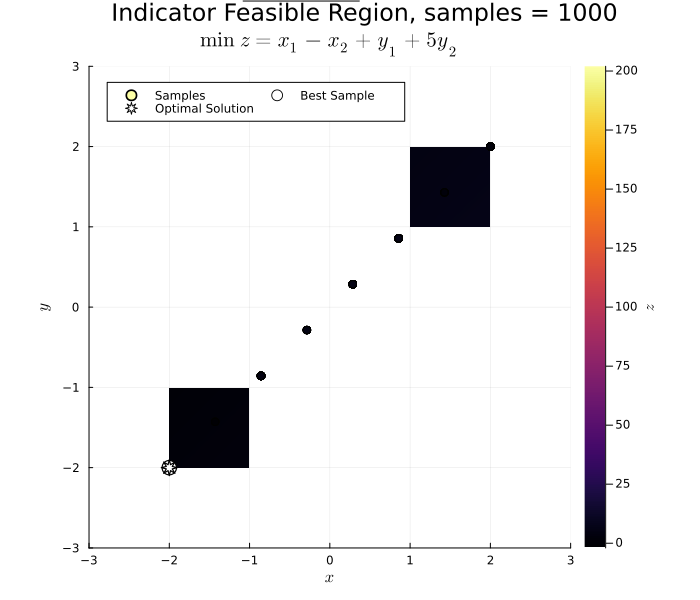

In [20]:
ind_region(int_model, [-2, -2])

$$
\begin{array}{rll}
\displaystyle \min_{x, y, Y} & x_1 - x_2 + y_1 + 5y_2 \\
            \textrm{s.t.} & Y_{1} \veebar Y_{2} \\
                ~ & \left[
                        \begin{array}{c}
                            Y_1 \\
                            -2 \leq x_{1}, x_{2} \leq -1 \\
                        \end{array}
                    \right] \bigvee
                    \left[
                        \begin{array}{c}
                            Y_2 \\
                            1 \leq x_{1}, x_{2} \leq 2 \\
                        \end{array}
                    \right] \\
                ~ & x_{i} \in [-2, 2] \\
                ~ & Y_{i} \in \{ \textrm{True}, \textrm{False} \}  & \forall i \\
                ~ & y_{i} \in \{ 0, 1 \}  & \forall i \\
                ~ & Y_{i} \iff y_{i} = 1  & \forall i \\
\end{array}
$$

In [15]:
function solve_model(config!::Function, optimizer = HiGHS.Optimizer; method = Indicator())
    model = GDPModel(optimizer)

    @variable(model, -2 <= x[1:2] <= 2)
    @variable(model, Y[1:2], Logical)
    y = binary_variable.(Y)

    @objective(model, Min, x[1] - x[2] + y[1] + 5y[2])

    @constraint(model, -2 .≤ x .≤ -1, Disjunct.([Y[1], Y[1]]))
    @constraint(model,  1 .≤ x .≤  2, Disjunct.([Y[2], Y[2]]))

    disjunction(model, Y, exactly1 = true)

    config!(model)

    optimize!(model; gdp_method = method)

    return model
end

solve_model(optimizer = HiGHS.Optimizer; method = Indicator()) = solve_model(identity, optimizer; method)

solve_model (generic function with 4 methods)

In [6]:
x⃰, z⃰ = let model = solve_model(HiGHS.Optimizer; method=Hull()) do m
        set_silent(m)
    end

    value.(model[:x]), objective_value(model)
end

([-2.0, -1.0], 0.0)

In [7]:
using Plots

# Make plots look professional
Plots.default(;
    fontfamily = "Computer Modern",
    plot_titlefontsize  = 16,
    titlefontsize       = 14,
    guidefontsize       = 12,
    legendfontsize      = 10,
    tickfontsize        = 10,
)

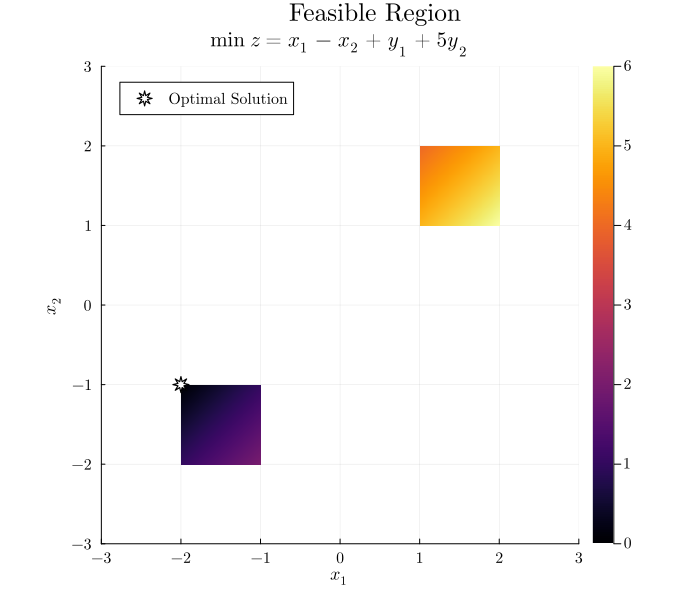

In [7]:
function feasible_region(x⃰ = nothing; ns::Integer = 1_000)
    x1 = x2 = range(-3, 3; length = ns)

    # y1 = 1
    objective1(x1, x2) = x1 - x2 + 1
    feasible1(x1, x2) = -2 ≤ x1 ≤ -1 && -2 ≤ x2 ≤ -1
    coloring1(x1, x2) = ifelse(feasible1(x1, x2), objective1(x1, x2), NaN)

    # y2 = 1
    objective2(x1, x2) = x1 - x2 + 5
    feasible2(x1, x2) = 1 ≤ x1 ≤ 2 && 1 ≤ x2 ≤ 2
    coloring2(x1, x2) = ifelse(feasible2(x1, x2), objective2(x1, x2), NaN)

    plt = plot(;
        size         = (700, 600),
        plot_title   = raw"Feasible Region",
        title        = raw"$ \min~z = x_{1} - x_{2} + y_{1} + 5y_{2} $",
        xlabel       = raw"$x_{1}$",
        ylabel       = raw"$x_{2}$",
        xlims        = (-3, 3),
        ylims        = (-3, 3),
        clims        = ( 0, 6),
        aspect_ratio = :equal,
    )

    heatmap!(
        plt, x1, x2, coloring1;
        legend  = :topleft,
        xlims   = extrema(x1),
        ylims   = extrema(x2),
        z_order = :back,
    )

    heatmap!(
        plt, x1, x2, coloring2;
        legend  = :topleft,
        xlims   = extrema(x1),
        ylims   = extrema(x2),
        z_order = :back,
    )

    if !isnothing(x⃰)
        scatter!(
            plt,
            [x⃰[1]],
            [x⃰[2]];
            color      = :white,
            marker     = :star8,
            markersize = 8,
            label      = "Optimal Solution",
            z_order    = :front,
        )
    end

    plt
end

feasible_region(x⃰)

## Big-M Reformulation

In [16]:
bigm_model = solve_model(
    () -> ToQUBO.Optimizer(DWave.Neal.Optimizer),
    method=BigM(3.0, false)
) do m
    set_attribute(m, "num_reads",  1_000)

    set_attribute.(m[:x], ToQUBO.Attributes.VariableEncodingMethod(), ToQUBO.Encoding.Unary())
    set_attribute.(m[:x], ToQUBO.Attributes.VariableEncodingBits(), 4)
end

compilation_summary(bigm_model)
solution_summary(bigm_model)
sampling_summary(bigm_model, z⃰)

⋄ Compilation Summary

⋄ Solver: D-Wave Neal Simulated Annealing Sampler

⋄ Number of variables: 34
  Encoding ………………… 10
  Slack ………………………… 24
  Quadratization … 0

⋄ Density
  Linear ……………………… 1.0
  Quadratic ……………… 0.2798573975044563

⋄ Coefficient Range
  Lower Bound ………… -734.0
  Upper Bound ………… 360.0

⋄ Constant Offset: 2235.0

⋄ Work counters
  Compiltaion Time (sec) : 0.74806711

⋄ Sampling Summary

⋄ Number of samples: 3545

⋄ Best energy: 0.0

⋄ Time-to-target (sec): 5531.292395840882



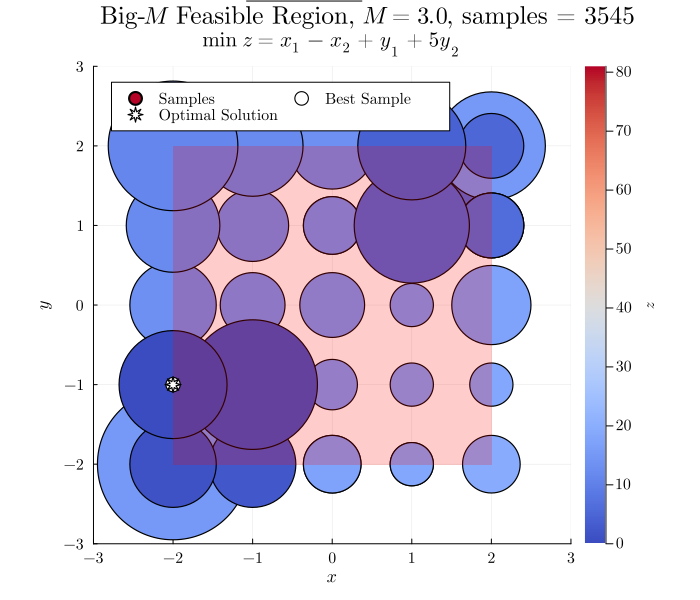

In [18]:
function bigm_region(M::Number, nr::Integer)
    return plot(;
        size         = (700, 600),
        plot_title   = "Big-\$M\$ Feasible Region, \$M = $(M)\$, samples = $(nr)",
        title        = raw"$ \min~z = x_{1} - x_{2} + y_{1} + 5y_{2} $",
        xlabel       = raw"$x$",
        ylabel       = raw"$y$",
        xlims        = (-3, 3),
        ylims        = (-3, 3),
        # clims        = (-6, 6),
        aspect_ratio = :equal,
        legend_columns = 2,
        colorbar_title = raw"$ z $",
    )
end

function bigm_region!(plt, x⃰, x, M::Number; ns::Integer = 1_000, color = :balance)
    x1 = x2 = range(-3, 3; length = ns)

    # y1 = 1
    objective1(x1, x2) = x1 - x2 + 1
    feasible1(x1, x2) = -2 ≤ x1 ≤ -1 && -2 ≤ x2 ≤ -1
    coloring1(x1, x2) = ifelse(feasible1(x1, x2), objective1(x1, x2), NaN)

    # y2 = 1
    objective2(x1, x2) = x1 - x2 + 5
    feasible2(x1, x2) = 1 ≤ x1 ≤ 2 && 1 ≤ x2 ≤ 2
    coloring2(x1, x2) = ifelse(feasible2(x1, x2), objective2(x1, x2), NaN)

    envelope(x1, x2, M = M) = (-2 - M <= x1 <= -1 + M) &&
                              (-2 - M <= x2 <= -1 + M) &&
                              (1 - M <= x1 <= 2 + M)   &&
                              (1 - M <= x2 <= 2 + M)
    
    shading(x1, x2) = ifelse(envelope(x1, x2), 1.0, NaN)

    heatmap!(
        plt, x1, x2, shading;
        color = :red,
        alpha = 0.2,
        xlims = extrema(x1),
        ylims = extrema(x2),
        colorbar_entry = false,
    )

    heatmap!(
        plt, x1, x2, coloring1;
        color = color,
        xlims = extrema(x1),
        ylims = extrema(x2),
        z_order = :back,
    )

    heatmap!(
        plt, x1, x2, coloring2;
        color = color,
        xlims = extrema(x1),
        ylims = extrema(x2),
        z_order = :back,
    )

    scatter!(
        plt,
        [x[1]],
        [x[2]];
        color  = :white,
        marker = :circle,
        markersize = 8,
        label  = "Best Sample",
    )

    scatter!(
        plt,
        [x⃰[1]],
        [x⃰[2]];
        color  = :white,
        marker = :star8,
        markersize = 8,
        label  = "Optimal Solution",
    )

    plt
end

function bigm_region(model::JuMP.Model, x⃰, M::Number; nr::Integer=result_count(model), ns::Integer = 1_000, color = :balance)
    plt = bigm_region(M, nr)

    x1 = reverse!([value(model[:x][1]; result=i) for i = 1:nr])
    x2 = reverse!([value(model[:x][2]; result=i) for i = 1:nr])
    z  = reverse!([objective_value(model; result=i) for i = 1:nr])
    r  = reverse!([reads(model; result=i) for i = 1:nr])
    x  = [x1[end], x2[end]]

    scatter!(
        plt,
        x1,
        x2;
        zcolor     = z,
        color      = color,
        marker     = :circle,
        markersize = 4r,
        label      = "Samples",
        z_order    = :front,
    )

    bigm_region!(plt, x⃰, x, M; ns, color)

    plt
end

bigm_region(bigm_model, x⃰, 3.0; color = :coolwarm)

## Hull Reformulation

In [22]:
hull_model = solve_model(
    () -> ToQUBO.Optimizer(DWave.Neal.Optimizer),
    method=Hull()
) do m
    set_attribute(m, "num_reads",  1_000)
    set_attribute(m, "num_sweeps", 2_000)

    set_attribute(m, ToQUBO.Attributes.DefaultVariableEncodingBits(), 4)
    set_attribute(m, ToQUBO.Attributes.DefaultVariableEncodingMethod(), ToQUBO.Encoding.Unary())
    
    # set_attribute.(m[:x], ToQUBO.Attributes.VariableEncodingMethod(), ToQUBO.Encoding.Unary())
    # set_attribute.(m[:x], ToQUBO.Attributes.VariableEncodingBits(), 4)
end

compilation_summary(hull_model)
solution_summary(hull_model)
sampling_summary(hull_model, z⃰)

⋄ Compilation Summary

⋄ Solver: D-Wave Neal Simulated Annealing Sampler

⋄ Number of variables: 82
  Encoding ………………… 26
  Slack ………………………… 56
  Quadratization … 0

⋄ Density
  Linear ……………………… 1.0
  Quadratic ……………… 0.15206263173742848

⋄ Coefficient Range
  Lower Bound ………… -225.0
  Upper Bound ………… 740.0

⋄ Constant Offset: 1095.0

⋄ Work counters
  Compiltaion Time (sec) : 0.137337058

⋄ Sampling Summary

⋄ Number of samples: 1000

⋄ Best energy: 1.0

⋄ Time-to-target (sec): -Inf



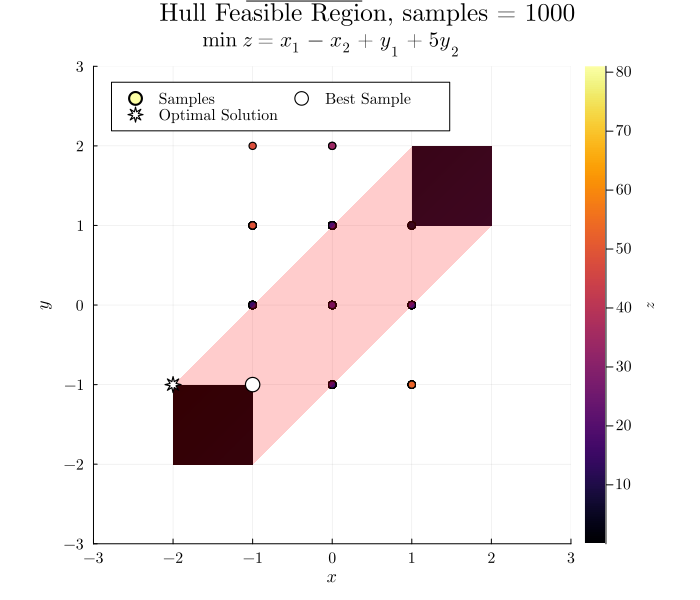

In [24]:
function hull_region(nr::Integer)
    return plot(;
        size         = (700, 600),
        plot_title   = "Hull Feasible Region, samples = $(nr)",
        title        = raw"$ \min~z = x_{1} - x_{2} + y_{1} + 5y_{2} $",
        xlabel       = raw"$x$",
        ylabel       = raw"$y$",
        xlims        = (-3, 3),
        ylims        = (-3, 3),
        # clims        = (-6, 6),
        aspect_ratio = :equal,
        legend_columns = 2,
        colorbar_title = raw"$z$",
    )
end

function hull_region!(plt, x⃰, x; ns::Integer = 1_000)
    x1 = x2 = range(-3, 3; length = ns)
    
    # y1 = 1
    objective1(x1, x2) = x1 - x2 + 1
    feasible1(x1, x2) = -2 ≤ x1 ≤ -1 && -2 ≤ x2 ≤ -1
    coloring1(x1, x2) = ifelse(feasible1(x1, x2), objective1(x1, x2), NaN)

    # y2 = 1
    objective2(x1, x2) = x1 - x2 + 5
    feasible2(x1, x2) = 1 ≤ x1 ≤ 2 && 1 ≤ x2 ≤ 2
    coloring2(x1, x2) = ifelse(feasible2(x1, x2), objective2(x1, x2), NaN)

    envelope(x1, x2) = (-1 ≤ x1 - x2 ≤ 1) && (-2 ≤ x1 ≤ 2) && (-2 ≤ x2 ≤ 2) 
    shading(x1, x2)  = ifelse(envelope(x1, x2), 1.0, NaN)

    heatmap!(
        plt, x1, x2, shading;
        color = :red,
        alpha = 0.2,
        xlims = extrema(x1),
        ylims = extrema(x2),
        colorbar_entry = false,
    )

    heatmap!(
        plt, x1, x2, coloring1;
        xlims = extrema(x1),
        ylims = extrema(x2),
        z_order = :back,
    )

    heatmap!(
        plt, x1, x2, coloring2;
        xlims = extrema(x1),
        ylims = extrema(x2),
        z_order = :back,
    )

    scatter!(
        plt,
        [x[1]],
        [x[2]];
        color  = :white,
        marker = :circle,
        markersize = 8,
        label  = "Best Sample",
    )

    scatter!(
        plt,
        [x⃰[1]],
        [x⃰[2]];
        color  = :white,
        marker = :star8,
        markersize = 8,
        label  = "Optimal Solution",
    )

    plt
end

function hull_region(model::JuMP.Model, x⃰; nr::Integer=result_count(model), ns::Integer = 1_000)
    plt = hull_region(nr)

    x1 = reverse!([value(model[:x][1]; result=i) for i = 1:nr])
    x2 = reverse!([value(model[:x][2]; result=i) for i = 1:nr])
    z  = reverse!([objective_value(model; result=i) for i = 1:nr])
    r  = reverse!([reads(model; result=i) for i = 1:nr])
    x  = [x1[end], x2[end]]

    scatter!(
        plt,
        x1,
        x2;
        zcolor     = z,
        marker     = :circle,
        markersize = 4r,
        label      = "Samples",
        z_order    = :front,
    )

    hull_region!(plt, x⃰, x; ns)

    plt
end

hull_region(hull_model, x⃰)

## Indicator Reformulation

In [25]:
ind_model = solve_model(
    () -> ToQUBO.Optimizer(DWave.Neal.Optimizer),
    method=Indicator()
) do m
    set_attribute(m, "num_reads",  1_000)

    

    set_attribute(m, ToQUBO.Attributes.DefaultVariableEncodingBits(), 4)
    set_attribute(m, ToQUBO.Attributes.DefaultVariableEncodingMethod(), ToQUBO.Encoding.Unary())
    # set_attribute.(m[:x], ToQUBO.Attributes.VariableEncodingMethod(), ToQUBO.Encoding.Binary())
    # set_attribute.(m[:x], ToQUBO.Attributes.VariableEncodingBits(), 5)
end

compilation_summary(ind_model)
solution_summary(ind_model)
sampling_summary(ind_model, z⃰)

⋄ Compilation Summary

⋄ Solver: D-Wave Neal Simulated Annealing Sampler

⋄ Number of variables: 158
  Encoding ………………… 10
  Slack ………………………… 20
  Quadratization … 128

⋄ Density
  Linear ……………………… 0.8734177215189873
  Quadratic ……………… 0.03555591389180037

⋄ Coefficient Range
  Lower Bound ………… -180.0
  Upper Bound ………… 740.0

⋄ Constant Offset: 15.0

⋄ Work counters
  Compiltaion Time (sec) : 0.018241085

⋄ Sampling Summary

⋄ Number of samples: 1000

⋄ Best energy: 1.0

⋄ Time-to-target (sec): -Inf



In [18]:
function ind_region(nr::Integer)
    return plot(;
        size         = (700, 600),
        plot_title   = "Indicator Feasible Region, samples = $(nr)",
        title        = raw"$ \min~z = x_{1} - x_{2} + y_{1} + 5y_{2} $",
        xlabel       = raw"$x$",
        ylabel       = raw"$y$",
        xlims        = (-3, 3),
        ylims        = (-3, 3),
        # clims        = (-6, 6),
        aspect_ratio = :equal,
        legend_columns = 2,
        colorbar_title = raw"$z$",
    )
end

function ind_region!(plt, x⃰, x; ns::Integer = 1_000)
    x1 = x2 = range(-3, 3; length = ns)
    
    # y1 = 1
    objective1(x1, x2) = x1 - x2 + 1
    feasible1(x1, x2) = -2 ≤ x1 ≤ -1 && -2 ≤ x2 ≤ -1
    coloring1(x1, x2) = ifelse(feasible1(x1, x2), objective1(x1, x2), NaN)

    # y2 = 1
    objective2(x1, x2) = x1 - x2 + 5
    feasible2(x1, x2) = 1 ≤ x1 ≤ 2 && 1 ≤ x2 ≤ 2
    coloring2(x1, x2) = ifelse(feasible2(x1, x2), objective2(x1, x2), NaN)

    envelope(x1, x2) = (-1 ≤ x1 - x2 ≤ 1) && (-2 ≤ x1 ≤ 2) && (-2 ≤ x2 ≤ 2) 
    shading(x1, x2)  = ifelse(envelope(x1, x2), 1.0, NaN)

    # heatmap!(
    #     plt, x1, x2, shading;
    #     color = :red,
    #     alpha = 0.2,
    #     xlims = extrema(x1),
    #     ylims = extrema(x2),
    #     colorbar_entry = false,
    # )

    heatmap!(
        plt, x1, x2, coloring1;
        xlims = extrema(x1),
        ylims = extrema(x2),
        z_order = :back,
    )

    heatmap!(
        plt, x1, x2, coloring2;
        xlims = extrema(x1),
        ylims = extrema(x2),
        z_order = :back,
    )

    scatter!(
        plt,
        [x[1]],
        [x[2]];
        color  = :white,
        marker = :circle,
        markersize = 8,
        label  = "Best Sample",
    )

    scatter!(
        plt,
        [x⃰[1]],
        [x⃰[2]];
        color  = :white,
        marker = :star8,
        markersize = 8,
        label  = "Optimal Solution",
    )

    plt
end

function ind_region(model::JuMP.Model, x⃰; nr::Integer=result_count(model), ns::Integer = 1_000)
    plt = ind_region(nr)

    x1 = reverse!([value(model[:x][1]; result=i) for i = 1:nr])
    # x2 = reverse!([value(model[:x][2]; result=i) for i = 1:nr])
    z  = reverse!([objective_value(model; result=i) for i = 1:nr])
    r  = reverse!([reads(model; result=i) for i = 1:nr])
    x  = [x1[end], x1[end]]

    scatter!(
        plt,
        x1,
        x1;
        zcolor     = z,
        marker     = :circle,
        markersize = 4r,
        label      = "Samples",
        z_order    = :front,
    )

    ind_region!(plt, x⃰, x; ns)

    plt
end

# ind_region(ind_model, x⃰; nr = 100)

ind_region (generic function with 2 methods)

In [12]:
g = unsafe_backend(ind_model).g
c = keys(g)

KeySet for a Dict{MathOptInterface.ConstraintIndex, PseudoBooleanOptimization.PBF{MathOptInterface.VariableIndex, Float64}} with 5 entries. Keys:
  MathOptInterface.ConstraintIndex{MathOptInterface.VectorAffineFunction{Float6…
  MathOptInterface.ConstraintIndex{MathOptInterface.VectorAffineFunction{Float6…
  MathOptInterface.ConstraintIndex{MathOptInterface.ScalarAffineFunction{Float6…
  MathOptInterface.ConstraintIndex{MathOptInterface.VectorAffineFunction{Float6…
  MathOptInterface.ConstraintIndex{MathOptInterface.VectorAffineFunction{Float6…